In [3]:
                                                                                                                                                                                                                                                                        from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from keras.layers import Bidirectional
import datetime
import matplotlib.pyplot as plt
import pandas as pd

# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dfav = read_csv('data/appcpc/Jan10-Jul20/anand_vihar_jan19_jul20_8h.csv')
dfav.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']
# dfav.index.name = 'From Date'
dfav['PM2.5'].fillna(0, inplace=True)

dfbw= read_csv('data/appcpc/Jan10-Jul20/Bawana_jan19-jul20_8h.csv')
dfbw.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']
# dfbw.index.name = 'From Date'
dfbw['PM2.5'].fillna(0, inplace=True)

dfvv = read_csv('data/appcpc/Jan10-Jul20/vivek_vihar_jan19_jul20_8h.csv')
dfvv.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']
# dfvv.index.name = 'From Date'
dfvv['PM2.5'].fillna(0, inplace=True)


dfwz = read_csv('data/appcpc/Jan10-Jul20/Wazirpur_8h_jan19-july20.csv')
dfwz.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']
# dfwz.index.name = 'From Date'
dfwz['PM2.5'].fillna(0, inplace=True)


dfdt = read_csv('data/appcpc/Jan10-Jul20/DTU_8h_jan19-jul20.csv')
dfdt.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']
# dfdt.index.name = 'From Date'
dfdt['PM2.5'].fillna(0, inplace=True)

frames=[dfav,dfbw,dfvv,dfwz,dfdt]
df=pd.concat(frames)

# drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows
print(df.head(5))


# save to file


# print(dfav[])

df = df.replace(to_replace='None', value=np.nan).dropna()





/home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


          From Date    PM10      NO     NO2    WS    CO Benzene     NOx  \
0  01-01-2019 00:00  752.78  179.68  111.66   0.3  3.52   20.45   251.7   
1  01-01-2019 08:00  408.19  135.13  148.64  0.53  4.57    9.75  189.21   
2  01-01-2019 16:00  475.85  123.27  177.02  0.31  5.66   17.79  176.38   
3  02-01-2019 00:00  771.27  357.61  106.05   0.3  5.96    20.9  350.56   
4  02-01-2019 08:00  495.06    75.6  125.28  1.13  1.56   10.11  128.26   

   Ozone    SO2     NH3 Toluene   PM2.5  
0  22.86  10.79   93.35   58.33  492.03  
1  22.68  13.86   104.4   31.63  266.16  
2  26.04  21.74   89.24   89.25   382.5  
3  61.84   5.99  109.64   99.34  545.28  
4  34.37  19.54  108.53   57.46  344.22  


In [4]:
# print(df['PM10'])
df = df.replace(to_replace='None', value=np.nan).dropna()
df['Date'] = pd.to_datetime(df['From Date']) 
df['year'] = df['Date'].dt.year 
df['month'] = df['Date'].dt.month 
df['day'] = df['Date'].dt.day 
df['hour'] = df['Date'].dt.hour 
df['minute'] = df['Date'].dt.minute


In [5]:
df_train = df[(df["year"] <2020) | (df['month']<=2)]

df_test=df[(df["year"] >2019) & (df['month']<8) & (df['month']>2)]
df.to_csv('pollution.csv')
df_train.to_csv('train_pollution.csv')
df_test.to_csv('test_pollution.csv')

In [6]:
dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,1:-6]
values_test=values_test[:,1:-6]
print(values_train.shape,values_test.shape)

(3369, 12) (870, 12)


(367, 17)


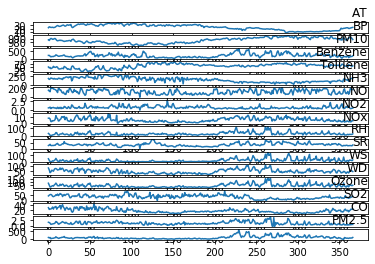

In [2]:
# from pandas import read_csv
# from matplotlib import pyplot
# # load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# values = dataset.values

# print(values.shape)
# # specify columns to plot
# groups=[]
# for i in range(values.shape[1]):
#     groups.append(i)
# # groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13,14,]
# # print(groups)
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
#     pyplot.subplot(len(groups), 1, i)
#     pyplot.plot(values[:, group])
# #     print(group)
#     pyplot.title(dataset.columns[group], y=1, loc='right')
#     i += 1
# # pyplot.plot(values[:,0])
# # #     print(group)
# # pyplot.title(dataset.columns[2], y=0.5, loc='right')
# # pyplot.show()
# # # values[:,0]

In [9]:
n_hours=1
n_out= 1
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
print(values.shape)
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
# values = values.astype('float32')
# # normalize features
# # scaler = MinMaxScaler(feature_range=(0, 1))
# # print(values.shape)
# # scaled = scaler.fit_transform(values)
# # print(len(scaled))
# X, y = split_sequences(values, n_hours, n_out)
# # for i in range(0,1):
# #     print(X[i], y[i])
# print(X.shape,y.shape)


(4504, 13)


In [14]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import array


def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)






def MODEL_FNN_adam(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
#     train_X=train_X.flatten()
    print(train_X.shape)
    train_X=np.reshape(train_X,(train_X.shape[0],n_hours*n_features))
    test_X=np.reshape(test_X,(test_X.shape[0],n_hours*n_features))
    val_X=np.reshape(val_X,(val_X.shape[0],n_hours*n_features))
    model = Sequential()
    model.add(Dense(256, input_dim=train_X.shape[1], activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.add(Dense(n_out, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))

def MODEL_FNN_sgd(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
#     train_X=train_X.flatten()
    print(train_X.shape)
    train_X=np.reshape(train_X,(train_X.shape[0],n_hours*n_features))
    test_X=np.reshape(test_X,(test_X.shape[0],n_hours*n_features))
    val_X=np.reshape(val_X,(val_X.shape[0],n_hours*n_features))
    model = Sequential()
    model.add(Dense(256, input_dim=train_X.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_out, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))



def MODEL_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_hours,n_features)))

    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))

def MODEL_Bi_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_hours,n_features))))

    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_hours,n_features))))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))


def MODEL_EN_DC(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
    val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))
    model = Sequential()
    model.add(LSTM(200, activation='relu',input_shape=(n_hours,n_features)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
#     model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))),yhat11,test_y)

def main(n_out_max,n_hour_max):
    dataset = read_csv('pollution.csv', header=0, index_col=0)
    values = dataset.values  
    values = values.astype('float32')
# normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    print(values.shape)
    scaled = scaler.fit_transform(values)
    print(len(scaled))
    result=np.zeros((n_out_max,n_hour_max),dtype=np.float32)
    for n_out in range (1,n_out_max+1):
        for n_hours in range(1,n_hour_max+1):
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours)
            X, y = split_sequences(scaled, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
            result[n_out-1,n_hours-1]=error
      
    return result
            
            
            
            
n_out_max,n_hour_max= 10,5

# r5=main(5,10)
import datetime
out_range=[10]
dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,1:-6]
values_test=values_test[:,1:-6]

values_train = values_train.astype('float32')
values_test = values_test.astype('float32')

In [7]:

# result=np.zeros((len(out_range),10),dtype=np.float32)
result= []
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float

dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,1:-6]
values_test=values_test[:,1:-6]

values_train = values_train.astype('float32')
values_test = values_test.astype('float32')
for i,k in enumerate(out_range):
    for j in range(1,2):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
#             X, y = split_sequences(values, n_hours, n_out)
            train_X, train_y = split_sequences(values_train,n_hours,n_out)
            val_X, val_y = split_sequences(values_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[400:852,:,:],val_y[400:852,:]
            val_X, val_y = val_X[0:400,:,:],val_y[0:400,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            error=MODEL_FNN_sgd(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result.append(error)
            
        
result=np.array(result)
np.savetxt("10i_"+str(result.shape[1])+"o_FNN_sgd_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")

W0727 11:54:16.563438 139686236600064 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 11:54:16.702642 139686236600064 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 11:54:16.704789 139686236600064 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 11:54:16.747227 139686236600064 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Pl

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
(852, 10, 11) (852, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (3351, 10, 11) (3351, 10) (452, 10, 11) (452, 10)
val X, val y (400, 10, 11) (400, 10)
(3351, 10, 11)


W0727 11:54:16.769717 139686236600064 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0727 11:54:16.774148 139686236600064 deprecation.py:323] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0727 11:54:17.002146 139686236600064 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



RMSE error using  10  state size to predict  10  step is = [1687.1726 1703.3126 1684.3483 1684.8247 1685.0763 1684.6573 1684.4218
 1683.5906 1683.5874 1683.9226]


In [62]:
result= []
for i,k in enumerate(out_range):
    for j in range(1,):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            train_X, train_y = split_sequences(values_train,n_hours,n_out)
            val_X, val_y = split_sequences(values_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[400:852,:,:],val_y[400:852,:]
            val_X, val_y = val_X[0:400,:,:],val_y[0:400,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL_FNN_adam(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result.append(error)
            
        
result=np.array(result)
np.savetxt("10i_"+str(result.shape[1])+"o_FNN_adam_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
(852, 10, 11) (852, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (3351, 10, 11) (3351, 10) (452, 10, 11) (452, 10)
val X, val y (400, 10, 11) (400, 10)
(3351, 10, 11)
RMSE error using  10  state size to predict  10  step is = [1687.1726 1686.9001 1684.3483 1684.8247 1685.0763 1684.6573 1684.4218
 1683.5906 1683.5874 1683.9226]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  2
(852, 10, 11) (852, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (3351, 10, 11) (3351, 10) (452, 10, 11) (452, 10)
val X, val y (400, 10, 11) (400, 10)
(3351, 10, 11)
RMSE error using  10  state size to predict  10  step is = [1703.589  1686.9001 1700.7543 1684.8247 1685.0763 1684.6573 1700.8264
 1683.5906 1683.5874 1683.9226]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  3
(852, 10

RMSE error using  10  state size to predict  10  step is = [1687.1726 1686.9001 1684.3483 1684.8247 1685.0763 1684.6573 1684.4218
 1683.5906 1683.5874 1683.9226]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  20
(852, 10, 11) (852, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (3351, 10, 11) (3351, 10) (452, 10, 11) (452, 10)
val X, val y (400, 10, 11) (400, 10)
(3351, 10, 11)
RMSE error using  10  state size to predict  10  step is = [1687.1726 1703.3126 1684.3483 1684.8247 1685.0763 1701.065  1684.4218
 1683.5906 1683.5874 1683.9226]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  21
(852, 10, 11) (852, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (3351, 10, 11) (3351, 10) (452, 10, 11) (452, 10)
val X, val y (400, 10, 11) (400, 10)
(3351, 10, 11)
RMSE error using  10  state size to predict  10  step is = [1687.1726 1686.9001 1684.3483 1684.8247 1685.0

In [ ]:
result= []
for i,k in enumerate(out_range):
    for j in range(1,4):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            train_X, train_y = split_sequences(values_train,n_hours,n_out)
            val_X, val_y = split_sequences(values_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[400:852,:,:],val_y[400:852,:]
            val_X, val_y = val_X[0:400,:,:],val_y[0:400,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            error=MODEL_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result.append(error)
            
        
result=np.array(result)
np.savetxt("10i_"+str(result.shape[1])+"o_LSTM_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
(852, 10, 11) (852, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (3351, 10, 11) (3351, 10) (452, 10, 11) (452, 10)
val X, val y (400, 10, 11) (400, 10)
RMSE error using  10  state size to predict  10  step is = [ 984.3997 1561.0587 1743.3611 2033.1942 2607.3203 2549.747  2936.8887
 3521.6306 3535.2332 3489.8276]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  2
(852, 10, 11) (852, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (3351, 10, 11) (3351, 10) (452, 10, 11) (452, 10)
val X, val y (400, 10, 11) (400, 10)
RMSE error using  10  state size to predict  10  step is = [ 667.07074  900.2795  1022.54565 1138.2212  1189.4921  1242.9229
 1347.1564  1505.805   1611.873   1683.8087 ]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  3
(852, 10, 11) (852, 10)
train

In [16]:
result= []
for i,k in enumerate(out_range):
    for j in range(1,2):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            train_X, train_y = split_sequences(values_train,n_hours,n_out)
            val_X, val_y = split_sequences(values_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[400:852,:,:],val_y[400:852,:]
            val_X, val_y = val_X[0:400,:,:],val_y[0:400,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            error=MODEL_Bi_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result.append(error)
            
        
result=np.array(result)
np.savetxt("10i_"+str(result.shape[1])+"o_bi_LSTM_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")

W0727 12:49:38.035093 139700072916736 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 12:49:38.051503 139700072916736 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0727 12:49:38.066375 139700072916736 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 12:49:38.067845 139700072916736 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is dep

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
(852, 10, 11) (852, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (3351, 10, 11) (3351, 10) (452, 10, 11) (452, 10)
val X, val y (400, 10, 11) (400, 10)


W0727 12:49:39.464528 139700072916736 deprecation.py:323] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0727 12:49:41.785706 139700072916736 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0727 12:49:41.980125 139700072916736 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



RMSE error using  10  state size to predict  10  step is = [ 668.5189 1044.7133 1229.7838 1271.9037 1508.1089 1623.457  1637.5133
 1717.6722 1767.8479 1707.3414]


In [ ]:
result1= []
out_range=[10]
for i,k in enumerate(out_range):
    for j in range(1,3):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            train_X, train_y = split_sequences(values_train,n_hours,n_out)
            val_X, val_y = split_sequences(values_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[400:852,:,:],val_y[400:852,:]
            val_X, val_y = val_X[0:400,:,:],val_y[0:400,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            error,ypred,yori=MODEL_EN_DC(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result1.append(error)
            
        
result1=np.array(result1)
print(result1.shape)
print(result1)
result1=result1.reshape(result1.shape[0],result1.shape[1])
np.savetxt("10i_"+str(result1.shape[1])+"o_EN_DC_"+str(result1.shape[0])+"i.csv"+str(datetime.datetime.now()), result1, delimiter=",")

In [22]:
ypred.shape

(19, 10, 1)

In [ ]:
import matplotlib.pyplot as plt
# n_out_max=3
xlist = np.linspace(1, n_out_max, n_out_max)
ylist = np.linspace(1, n_out_max, n_out_max)
X, Y = np.meshgrid(xlist, ylist)
# Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, r)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Number of steps used in multivariate analysis x ')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('Number of steps predicted y')
plt.show()
print("Normalized RMSE Test")

In [ ]:
out_range=[1]
# result=np.zeros((len(out_range),10),dtype=np.float32)
result1= []
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            X, y = split_sequences(scaled, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result1.append(error)
            
        
result1



            
            
            
    
    
            
            

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
def show_results(r,method):
    x = datetime.datetime.now()
    u=np.mean(r,axis=0)
    sigma=np.std(r,axis=0)
    lower_bar= u-1.96*(sigma/(np.sqrt(1)))
    upper_bar= u+1.96*(sigma/(np.sqrt(1)))
    barWidth = 0.3
    bars1=u
    rl= np.arange(len(bars1))+1
    plt.bar(rl, bars1, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma/(np.sqrt(r.shape[0]))), capsize=7, label=method+' with using 10 multivariate steps for 30 iterations')
    plt.ylabel('mean of normalized RMSE for 30 iterations')
    plt.xlabel('Number of steps')
    plt.legend()
    plt.show()
    np.savetxt("10i_"+str(r.shape[1])+"o_"+method+"_"+str(r.shape[0])+"i"+str(datetime.datetime.now())+".csv", r, delimiter=",")
# show_results(r1_new)

(29, 10)


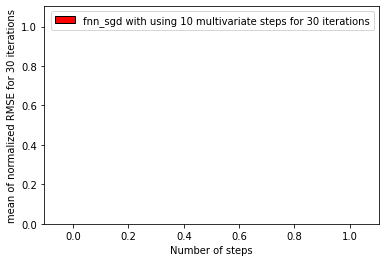

In [10]:
dsgd=read_csv('results/10i_10o_FNN_sgd_30i_colab_with_full.csv')
dSGD = dsgd.values
print(dSGD.shape)
show_results(dSGD,'fnn_sgd')

(1, 10)


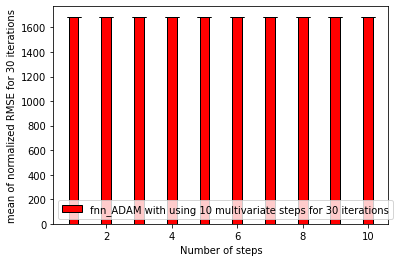

In [25]:
# dadam=read_csv('10i_10o_FNN_adam_30i.csv2020-07-27 06:17:47.538428')
ladam=[[1687.1726 ,1686.9001 ,1684.3483, 1684.8247, 1685.0763 ,1684.6573 ,1684.4218,
 1683.5906, 1683.5874 ,1683.9226]]
dADAM=np.array(ladam)
# dADAM = dadam.values
print(dADAM.shape)
show_results(dADAM,'fnn_ADAM')


9.737489013671875000e+02     831.492899
1.210776489257812500e+03    1098.416506
1.396545654296875000e+03    1328.846574
1.629268066406250000e+03    1479.148566
1.761837646484375000e+03    1647.483186
1.906840820312500000e+03    1830.260692
1.996497192382812500e+03    1945.061860
2.214586669921875000e+03    2026.655627
2.273685058593750000e+03    2069.030753
2.274079101562500000e+03    2070.632467
dtype: float64
9.737489013671875000e+02    172.169254
1.210776489257812500e+03    238.528065
1.396545654296875000e+03    341.459996
1.629268066406250000e+03    441.491785
1.761837646484375000e+03    537.957985
1.906840820312500000e+03    637.726564
1.996497192382812500e+03    779.544731
2.214586669921875000e+03    829.673226
2.273685058593750000e+03    826.639030
2.274079101562500000e+03    876.282741
dtype: float64


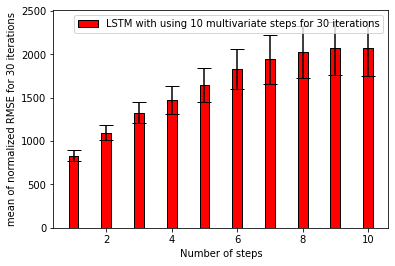

In [67]:
# dlstm=read_csv('10i_10o_LSTM_30i.csv2020-05-10 11:03:02_243465.csv')
# dLSTM = dlstm.values
dLSTM=read_csv('results/10i_10o_LSTM_30i2020-07-30_colab_with_full.csv')
print(np.mean(dLSTM))
print(np.std(dLSTM))
show_results(dLSTM,'LSTM')

(9, 10)


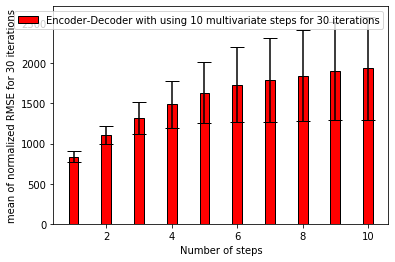

In [7]:
# den=read_csv('10i_10o_EN_DC_30i.csv2020-05-10 15:40:39_077980.csv')
lEN=[[1014.09717
   ,1096.8276   
   ,1279.9148   
   ,1382.6143   
   ,1512.9702   
   ,1572.573    
   ,1600.8066   
   ,1588.4052   
   ,1612.1232   
   ,1616.752    ]

  ,[ 757.4399   
   , 930.22424  
   ,1036.9641   
   ,1109.3658   
   ,1133.0293   
   ,1150.7404   
   ,1158.7914   
   ,1166.9806   
   ,1185.018    
   ,1190.5941   ]

  ,[ 775.08636  
   , 942.4178   
   ,1010.3597   
   ,1034.468    
   ,1058.1713   
   ,1063.81     
   ,1068.8236   
   ,1100.0187   
   ,1115.5554   
   ,1128.249    ]

  ,[1018.1749   
   ,1563.2941   
   ,2030.67     
   ,2352.331    
   ,2661.1892   
   ,2906.9456   
   ,3111.359    
   ,3356.0059   
   ,3626.9895   
   ,3805.0383   ]

  ,[ 756.4015   
   ,1043.1024   
   ,1247.2255   
   ,1423.5332   
   ,1487.0222   
   ,1534.9841   
   ,1565.8169   
   ,1581.6118   
   ,1591.4827   
   ,1609.5292   ]

  ,[ 829.8609   
   ,1039.5664   
   ,1176.5208   
   ,1239.3933   
   ,1308.8772   
   ,1313.2029   
   ,1332.2471   
   ,1330.4106   
   ,1351.6486   
   ,1344.2048   ]

  ,[ 888.4945   
   ,1104.9935   
   ,1189.066    
   ,1213.6727   
   ,1325.7197   
   ,1351.2096   
   ,1352.8827   
   ,1390.7533   
   ,1384.2114   
   ,1389.5021   ]

  ,[ 728.02167  
   ,1132.3594   
   ,1609.9431   
   ,2213.8728   
   ,2719.472    
   ,3163.1084   
   ,3365.4978   
   ,3516.4995   
   ,3627.315    
   ,3698.2275   ]

  ,[ 749.18286  
   ,1090.0675   
   ,1309.3542   
   ,1423.8892   
   ,1514.3691   
   ,1572.8219   
   ,1577.1084   
   ,1606.3649   
   ,1640.387    
   ,1662.8898]] 


dEN=np.array(lEN)
# dEN = den.values
print(dEN.shape)
show_results(dEN,'Encoder-Decoder')

(22, 10)


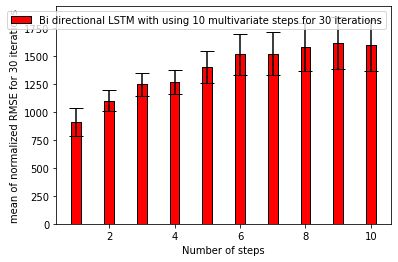

In [26]:
# dbi=read_csv('10i_10o_bi_LSTM_30i.csv2020-05-10 12:29:07_591213.csv')
# dBI = dbi.values
lBI=[[ 969.8882 ,1277.1731, 1468.2672 ,1460.928,  1623.5724 ,1763.8987, 1722.036,
 1803.5625, 1866.8588, 1810.4342],
 [ 722.07574  ,907.8592  , 979.9934  , 989.2812 , 1046.334 ,  1075.9742,
 1070.3185 , 1091.0967 , 1112.3413 , 1115.5602 ],
 [ 801.807  ,1034.9629 ,1161.4736, 1143.9906, 1209.6346 ,1305.8185, 1254.114,
 1274.3093 ,1290.1375,1268.6793],
[1028.353,1204.5212,1479.6134,1431.6039,1633.4913,1922.2136,1948.435
,1985.9891,2140.9133,2122.976],
[1640.4698,1639.1353,1635.2411,1632.848, 1590.988, 1560.6129,1545.1003
,1518.921, 1497.6561,1486.8616],
 [ 803.1738, 950.8526, 973.8418,1005.184 ,1068.7042,1067.9929,1085.2499
,1107.6813,1073.0375,1044.332 ],
 [ 622.2253,884.546, 1078.7385,1064.9238,1162.4537,1252.4735,1217.9684
,1252.9532,1303.0397,1276.6715],
 [ 710.741,  1013.4251, 1342.9054 ,1404.4167, 1698.2084, 1915.8339 ,1913.4025,
 2021.1522, 2025.5703, 1920.388 ],
 [ 591.4624  , 890.172  , 1045.6573,   988.75525, 1081.7245 , 1156.774,
 1120.539  , 1164.5605  ,1182.0413 , 1154.1305 ],
 [ 698.86774 , 898.51746 ,1082.5911 , 1082.691  , 1208.7532 , 1332.6791,
 1315.3162 , 1370.0671 , 1423.0651 , 1388.4113 ],
 [ 999.38367, 1013.37823 ,1022.23456 ,1045.7749 , 1059.6359 , 1074.2949,
 1091.809 ,  1120.1884 , 1106.2554 , 1143.2104 ],
 [ 968.32666 ,1159.3184  ,1506.1672 , 1663.4293 , 1962.8079 , 2393.0796,
 2602.024 ,  2801.4094 , 3021.4868,  2895.3755 ],
 [1335.7046 ,1515.6743 ,1647.6761, 1637.5294, 1726.7198 ,1741.4196 ,1723.0867,
 1746.9054 ,1694.588 , 1703.4254],
 [1100.119 , 1190.7557 ,1201.6648, 1201.4407, 1229.0417 ,1248.3105 ,1241.4988,
 1239.6946, 1244.5979, 1251.8176],
 [ 972.96387, 1260.2777 , 1630.9681 , 1739.5829 , 2401.7537 , 2788.5112,
 2800.4077 , 3072.7712 , 3211.6577 , 3189.779  ]
 ,[ 588.7389  ,845.2258 , 984.9668 ,1009.2586, 1128.3372 ,1195.3469, 1210.5182,
 1233.4716, 1253.8915, 1243.0809],
 [1643.3947 ,1643.8   , 1619.8284, 1622.4832, 1605.4521 ,1604.2609, 1623.4614,
 1627.3331, 1583.3892, 1562.5248],
 [ 629.9717 ,  908.1765 , 1014.37274, 1110.196 ,  1276.8256  ,1556.8937,
 1625.3396,  1802.9414,  1817.1638 , 1864.8885 ],
 [ 648.41754 , 990.9563 , 1217.7239 , 1223.3944 , 1408.6141 , 1533.6177,
 1518.2731,  1583.1321 , 1630.8342 , 1579.0361 ],
 [ 946.0659, 1064.5934, 1110.7546, 1124.073 , 1166.2177, 1181.4332 ,1171.2883,
 1178.2885 ,1190.9132 ,1191.2386],
[ 695.27234 , 941.598 ,  1154.9465,  1214.4712 , 1387.8839,  1536.0145,
 1558.7074 , 1673.5553 , 1744.5549  ,1712.1752 ],
[ 858.5309 , 1014.39746 ,1080.8525 , 1096.9081 , 1139.7615 , 1152.6874,
 1140.2477,  1150.6006  ,1164.087  , 1175.7429 ]]
 
dBI=np.array(lBI)
print(dBI.shape)
show_results(dBI,'Bi directional LSTM')

(1, 10)


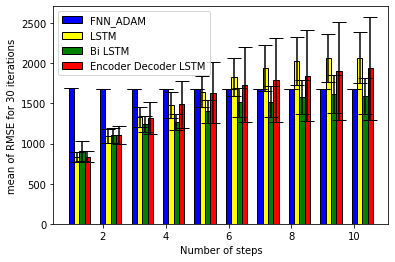

In [24]:
def show_results_Combined(r1,r2,r3,r4):
    x = datetime.datetime.now()
    print(r1.shape)
    u1=np.mean(r1,axis=0)
    u2=np.mean(r2,axis=0)
    u3=np.mean(r3,axis=0)
    u4=np.mean(r4,axis=0)
#     u5=np.mean(r5,axis=0)
    sigma1=np.std(r1,axis=0)
    sigma2=np.std(r2,axis=0)
    sigma3=np.std(r3,axis=0)
    sigma4=np.std(r4,axis=0)
#     sigma5=np.std(r5,axis=0)
#     lower_bar= u-1.96*(sigma/(np.sqrt(r.shape[0])))
#     upper_bar= u+1.96*(sigma/(np.sqrt(r.shape[0])))
    barWidth = 0.17
    bars1=u1
    bars2=u2
    bars3=u3
    bars4=u4
#     bars5=u5
    ra1= np.arange(len(bars1))+1
    ra2 = [y + barWidth for y in ra1]
    ra3 = [y + barWidth for y in ra2]
    ra4 = [y + barWidth for y in ra3]
#     ra5 = [y + barWidth for y in ra4]

#     plt.bar(ra1, bars1, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma1/(np.sqrt(r1.shape[0]))), capsize=7, label='FNN_Sgd')
    plt.bar(ra1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=1.96*(sigma1/(np.sqrt(r1.shape[0]))), capsize=7, label='FNN_ADAM')
    plt.bar(ra2, bars2, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=1.96*(sigma2/(np.sqrt(r2.shape[0]))), capsize=7, label='LSTM')
    plt.bar(ra3, bars3, width = barWidth, color = 'green', edgecolor = 'black', yerr=1.96*(sigma3/(np.sqrt(r3.shape[0]))), capsize=7, label='Bi LSTM')
    plt.bar(ra4, bars4, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma4/(np.sqrt(r4.shape[0]))), capsize=7, label='Encoder Decoder LSTM')
    

    plt.ylabel('mean of RMSE for 30 iterations')
    plt.xlabel('Number of steps')
    plt.legend()
    plt.show()
#     np.savetxt("10i_"+str(r.shape[1])+"o_"+method+"_"+str(r.shape[0])+"i"+str(datetime.datetime.now())+".csv", r, delimiter=",")
show_results_Combined(dADAM,dLSTM,dBI,dEN)

In [ ]:
def show_results_Combined(r1,r2,r3,r4):
    x = datetime.datetime.now()
    print(r1.shape)
    u1=np.mean(r1,axis=0)
    u2=np.mean(r2,axis=0)
    u3=np.mean(r3,axis=0)
    u4=np.mean(r4,axis=0)
#     u5=np.mean(r5,axis=0)
    sigma1=np.std(r1,axis=0)
    sigma2=np.std(r2,axis=0)
    sigma3=np.std(r3,axis=0)
    sigma4=np.std(r4,axis=0)
#     sigma5=np.std(r5,axis=0)
#     lower_bar= u-1.96*(sigma/(np.sqrt(r.shape[0])))
#     upper_bar= u+1.96*(sigma/(np.sqrt(r.shape[0])))
    barWidth = 0.17
#     bars1=u1
#     bars2=u2
#     bars3=u3
#     bars4=u4
# #     bars5=u5
#     ra1= np.arange(len(bars1))+1
#     ra2 = [y + barWidth for y in ra1]
#     ra3 = [y + barWidth for y in ra2]
#     ra4 = [y + barWidth for y in ra3]
# #     ra5 = [y + barWidth for y in ra4]

# #     plt.bar(ra1, bars1, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma1/(np.sqrt(r1.shape[0]))), capsize=7, label='FNN_Sgd')
#     plt.bar(ra1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=1.96*(sigma1/(np.sqrt(r1.shape[0]))), capsize=7, label='FNN_ADAM')
#     plt.bar(ra2, bars2, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=1.96*(sigma2/(np.sqrt(r2.shape[0]))), capsize=7, label='LSTM')
#     plt.bar(ra3, bars3, width = barWidth, color = 'green', edgecolor = 'black', yerr=1.96*(sigma3/(np.sqrt(r3.shape[0]))), capsize=7, label='Bi LSTM')
#     plt.bar(ra4, bars4, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma4/(np.sqrt(r4.shape[0]))), capsize=7, label='Encoder Decoder LSTM')
    

#     plt.ylabel('mean of RMSE for 30 iterations')
#     plt.xlabel('Number of steps')
#     plt.legend()
#     plt.show()
#     np.savetxt("10i_"+str(r.shape[1])+"o_"+method+"_"+str(r.shape[0])+"i"+str(datetime.datetime.now())+".csv", r, delimiter=",")
show_results_Combined(dADAM,dLSTM,dBI,dEN)

In [68]:
import plotly.graph_objects as go
dLSTM=[831.492899
,1098.416506
,1328.846574
,    1479.148566
,    1647.483186
,    1830.260692
,    1945.061860
,    2026.655627
,    2069.030753
,    2070.632467]

LSTMsigma=[172.169254
,  238.528065
,    341.459996
,    441.491785
,    537.957985
,    637.726564
,    779.544731
,    829.673226
,    826.639030
,    876.282741]
dLSTM=np.array(dLSTM)

u1=np.mean(dADAM,axis=0)
u2=dLSTM
print(u2)
u3=np.mean(dBI,axis=0)
print(u3)
u4=np.mean(dEN,axis=0)
sigma1=np.std(dADAM,axis=0)
sigma2=np.array(LSTMsigma)
sigma3=np.std(dEN,axis=0)
sigma4=np.std(dBI,axis=0)
fig = go.Figure()
df=pd.DataFrame()
df['ADAM']=u1

df['LSTM']=u2
df['EN']=u3
df['BI']=u4
df['steps']=[1,2,3,4,5,6,7,8,9,10]
fig.add_trace(go.Bar(x=df['steps'],
                y=df['ADAM'],
                     error_y=dict(type='data', array=sigma1),
                name='ADAM',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=df['steps'],
                y=df['LSTM'],
                error_y=dict(type='data', array=sigma2),
                name='LSTM',
                marker_color='rgb(200,125,150)'
                ))
fig.add_trace(go.Bar(x=df['steps'],
                y=df['EN'],
                error_y=dict(type='data', array=sigma3),
                name='Encoder Decoder',
                marker_color='rgb(13, 255, 20)'
                ))
fig.add_trace(go.Bar(x=df['steps'],
                y=df['BI'],
                error_y=dict(type='data', array=sigma4),
                name='Bi Directional ',
                marker_color='rgb(255, 10, 10)'
                ))

fig.update_layout(
    title='mean of RMSE for 30 iterations' ,
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='RMSE',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.5, # gap between bars of adjacent location coordinates.
    bargroupgap=0.05# gap between bars of the same location coordinate.
   
    
)
fig.show()

[ 831.492899 1098.416506 1328.846574 1479.148566 1647.483186 1830.260692
 1945.06186  2026.655627 2069.030753 2070.632467]
[ 907.99789818 1102.24166591 1247.2945     1267.87109773 1400.76888182
 1516.37006364 1522.68825909 1582.75384091 1617.18547727 1595.48815909]
